<a href="https://colab.research.google.com/github/christophergaughan/glycoform_chromatography_mabs/blob/main/glycoform_chromatography_model_unfinished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Mechanistic Model for Glycoform-Selective Antibody Chromatography

**AntibodyML Consulting LLC**

This notebook implements a hybrid mechanistic/machine learning model for simulating antibody binding to glycan-selective resins (ConA, boronate) and conventional affinity resins (Protein A/SuRe).

## Key Innovation
Unlike standard Protein A chromatography models, this framework specifically addresses **Fab glycosylation** detection - the "hidden" glycosylation sites that current ML antibody design tools miss.

### Scientific Basis
- ConA binds exposed Fab glycans but NOT buried Fc glycans at Asn297
- Boronate resins form reversible covalent bonds with cis-diol groups on glycans
- This enables separation of symmetric (non-Fab-glycosylated) vs asymmetric (Fab-glycosylated) IgG

---

## 1. Setup and Dependencies

In [1]:
# Install dependencies (uncomment for Colab)
# !pip install numpy scipy pandas matplotlib seaborn scikit-learn GPy pyDOE2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize, differential_evolution
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## 2. Literature-Derived Binding Parameters

### 2.1 Concanavalin A (ConA) Parameters
ConA binds α-D-mannosyl and α-D-glucosyl residues. Key finding: Fc glycans at Asn297 are **inaccessible** to ConA due to internal location, but Fab glycans are **exposed and accessible**.

| Ligand | KA (M⁻¹) | KD | Source |
|--------|----------|-----|--------|
| Glycogen | 3.93 × 10⁶ | 0.25 μM | QCM Biosensor |
| Mannan | 3.46 × 10⁵ | 2.89 μM | QCM Biosensor |
| Free Mannose | 1.04 × 10⁴ | 96 μM | BSI Free Solution |
| Free Glucose | 2.91 × 10³ | 344 μM | BSI Free Solution |
| IgG (mPGMA-ConA beads) | 1.39 × 10⁵ | 7.2 μM | Scatchard Analysis |
| qmax (IgG) | 109.1 mg/g | — | Theoretical capacity |

In [3]:
@dataclass
class ResinParameters:
    """Parameters for chromatography resin"""
    name: str
    ligand_type: str

    # Equilibrium parameters
    KA: float  # Association constant (M^-1)
    KD: float  # Dissociation constant (M)
    qmax: float  # Maximum binding capacity (mg/mL resin)

    # Kinetic parameters
    ka: float  # Association rate constant (M^-1 s^-1)
    kd: float  # Dissociation rate constant (s^-1)

    # Mass transfer parameters
    kf: float  # Film mass transfer coefficient (cm/s)
    Dp: float  # Effective pore diffusivity (cm^2/s)

    # Resin physical properties
    dp: float  # Particle diameter (μm)
    epsilon_p: float  # Particle porosity
    epsilon_b: float  # Bed void fraction

    # Operating conditions
    pH_bind: float
    pH_elute: float
    elution_agent: str


# Define resin parameter sets from literature
RESIN_LIBRARY = {
    'ConA_Agarose': ResinParameters(
        name='Concanavalin A Agarose',
        ligand_type='Lectin (Mannose/Glucose specific)',
        KA=1.39e5,  # M^-1 (IgG binding)
        KD=7.2e-6,  # M
        qmax=109.1,  # mg/g resin (theoretical)
        ka=1.0e4,  # M^-1 s^-1 (estimated)
        kd=0.072,  # s^-1 (calculated from KD*ka)
        kf=1.0e-3,  # cm/s (typical)
        Dp=1.0e-7,  # cm^2/s (typical for IgG in agarose)
        dp=90,  # μm (typical agarose bead)
        epsilon_p=0.65,
        epsilon_b=0.35,
        pH_bind=7.4,
        pH_elute=3.0,  # or competitive elution
        elution_agent='0.2M α-methyl-D-mannoside or 0.1M acetic acid'
    ),

    'Boronate_PBA': ResinParameters(
        name='Phenylboronic Acid Resin',
        ligand_type='Boronate (cis-diol specific)',
        KA=1.0e4,  # M^-1 (glycoprotein, pH dependent)
        KD=1.0e-4,  # M
        qmax=144.0,  # mg/g (OVA on PEI-PBA microspheres)
        ka=5.0e3,  # M^-1 s^-1 (estimated)
        kd=0.5,  # s^-1
        kf=1.0e-3,
        Dp=1.0e-7,
        dp=50,  # μm
        epsilon_p=0.60,
        epsilon_b=0.40,
        pH_bind=8.5,  # pKa of PBA ~8.86
        pH_elute=5.0,  # acidic conditions release
        elution_agent='0.1M sorbitol in acetate buffer pH 5.0'
    ),

    'MabSelect_SuRe': ResinParameters(
        name='MabSelect SuRe (Alkali-stabilized Protein A)',
        ligand_type='Protein A (Fc binding)',
        KA=1.0e8,  # M^-1 (high affinity Fc binding)
        KD=1.0e-8,  # M (~10 nM)
        qmax=35.0,  # mg/mL (dynamic binding capacity)
        ka=1.0e5,  # M^-1 s^-1
        kd=0.001,  # s^-1
        kf=2.0e-3,
        Dp=2.5e-7,
        dp=85,  # μm
        epsilon_p=0.70,
        epsilon_b=0.36,
        pH_bind=7.4,
        pH_elute=3.0,
        elution_agent='0.1M citric acid pH 3.0'
    ),

    'Capto_S_ImpRes': ResinParameters(
        name='Capto S ImpRes (Strong Cation Exchange)',
        ligand_type='Sulfonate (Charge-based)',
        KA=1.0e5,  # M^-1 (pH/salt dependent)
        KD=1.0e-5,  # M
        qmax=100.0,  # mg/mL
        ka=1.0e4,
        kd=0.1,
        kf=3.0e-3,
        Dp=3.0e-7,
        dp=40,  # μm (small particle)
        epsilon_p=0.65,
        epsilon_b=0.38,
        pH_bind=5.0,
        pH_elute=5.0,  # salt gradient
        elution_agent='NaCl gradient 0-500 mM'
    )
}

# Display resin parameters
resin_df = pd.DataFrame([vars(r) for r in RESIN_LIBRARY.values()])
resin_df[['name', 'ligand_type', 'KA', 'KD', 'qmax', 'pH_bind']]

,name,ligand_type,KA,KD,qmax,pH_bind
0,Concanavalin A Agarose,Lectin (Mannose/Glucose specific),139000.0,7.200000e-06,109.1,7.4
1,Phenylboronic Acid Resin,Boronate (cis-diol specific),10000.0,1.000000e-04,144.0,8.5
2,MabSelect SuRe (Alkali-stabilized Protein A),Protein A (Fc binding),100000000.0,1.000000e-08,35.0,7.4
3,Capto S ImpRes (Strong Cation Exchange),Sulfonate (Charge-based),100000.0,1.000000e-05,100.0,5.0


## 3. Mechanistic Column Model

### General Rate Model (GRM) for Affinity Chromatography

The model consists of:
1. **Convection-dispersion** in the mobile phase
2. **Film mass transfer** from bulk to particle surface
3. **Pore diffusion** within particles
4. **Adsorption kinetics** (Langmuir or SMA isotherm)

#### Governing Equations

**Mobile Phase Mass Balance:**
$$\frac{\partial C}{\partial t} = D_L \frac{\partial^2 C}{\partial z^2} - u \frac{\partial C}{\partial z} - \frac{3k_f(1-\varepsilon_b)}{\varepsilon_b r_p}(C - C_p|_{r=r_p})$$

**Pore Phase Mass Balance:**
$$\varepsilon_p \frac{\partial C_p}{\partial t} + (1-\varepsilon_p)\frac{\partial q}{\partial t} = \frac{D_p}{r^2}\frac{\partial}{\partial r}\left(r^2 \frac{\partial C_p}{\partial r}\right)$$

**Langmuir Kinetics:**
$$\frac{\partial q}{\partial t} = k_a C_p (q_{max} - q) - k_d q$$

In [4]:
@dataclass
class ColumnParameters:
    """Column geometry and operating parameters"""
    L: float  # Column length (cm)
    D: float  # Column diameter (cm)
    u: float  # Superficial velocity (cm/s)
    DL: float  # Axial dispersion coefficient (cm^2/s)

    @property
    def volume(self) -> float:
        return np.pi * (self.D/2)**2 * self.L

    @property
    def cross_section(self) -> float:
        return np.pi * (self.D/2)**2


class SimplifiedColumnModel:
    """
    Simplified lumped kinetic model for affinity chromatography.
    Uses tanks-in-series with film mass transfer and Langmuir kinetics.

    This is a computationally efficient approximation of the full GRM
    suitable for parameter estimation and Bayesian optimization.
    """

    def __init__(self, column: ColumnParameters, resin: ResinParameters):
        self.column = column
        self.resin = resin
        self.n_tanks = 50  # Number of discretization points

    def langmuir_isotherm(self, C: np.ndarray, q: np.ndarray) -> np.ndarray:
        """Calculate equilibrium loading using Langmuir isotherm"""
        qmax = self.resin.qmax
        KA = self.resin.KA
        return qmax * KA * C / (1 + KA * C)

    def adsorption_rate(self, C: np.ndarray, q: np.ndarray) -> np.ndarray:
        """Langmuir adsorption kinetics"""
        ka = self.resin.ka
        kd = self.resin.kd
        qmax = self.resin.qmax
        return ka * C * (qmax - q) - kd * q

    def ode_system(self, t: float, y: np.ndarray,
                   C_inlet: callable) -> np.ndarray:
        """
        ODE system for tanks-in-series model.

        State vector y = [C_1, ..., C_n, q_1, ..., q_n]
        """
        n = self.n_tanks
        C = y[:n]
        q = y[n:]

        # Tank volume and flow
        V_tank = self.column.volume / n
        Q = self.column.u * self.column.cross_section

        # Mass transfer
        kf = self.resin.kf
        rp = self.resin.dp / 2 / 1e4  # convert μm to cm
        epsilon_b = self.resin.epsilon_b
        epsilon_p = self.resin.epsilon_p

        # Effective mass transfer coefficient
        k_eff = 3 * kf * (1 - epsilon_b) / (epsilon_b * rp)

        # Initialize derivatives
        dCdt = np.zeros(n)
        dqdt = np.zeros(n)

        # Inlet concentration
        C_in = C_inlet(t)

        # Tank mass balances
        for i in range(n):
            C_prev = C_in if i == 0 else C[i-1]

            # Convection term
            conv = Q * (C_prev - C[i]) / (V_tank * epsilon_b)

            # Adsorption rate
            r_ads = self.adsorption_rate(C[i], q[i])

            # Mass balances
            dCdt[i] = conv - (1 - epsilon_b) / epsilon_b * r_ads
            dqdt[i] = r_ads

        return np.concatenate([dCdt, dqdt])

    def simulate_breakthrough(self, C_feed: float, t_load: float,
                             dt: float = 0.1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Simulate breakthrough curve for step input.

        Returns:
            t: time array
            C_out: outlet concentration
            q_avg: average column loading
        """
        # Inlet function (step input)
        def C_inlet(t):
            return C_feed if t <= t_load else 0.0

        # Time span
        t_span = (0, t_load * 1.5)
        t_eval = np.arange(0, t_span[1], dt)

        # Initial conditions (empty column)
        y0 = np.zeros(2 * self.n_tanks)

        # Solve ODE
        sol = solve_ivp(
            lambda t, y: self.ode_system(t, y, C_inlet),
            t_span, y0, t_eval=t_eval, method='LSODA'
        )

        t = sol.t
        C_out = sol.y[self.n_tanks - 1, :]  # Outlet tank concentration
        q_avg = np.mean(sol.y[self.n_tanks:, :], axis=0)  # Average loading

        return t, C_out, q_avg

    def calculate_dbc(self, C_feed: float, breakthrough_fraction: float = 0.10
                     ) -> float:
        """
        Calculate Dynamic Binding Capacity at specified breakthrough.
        """
        # Estimate loading time
        t_load_est = self.resin.qmax * self.column.volume / (
            self.column.u * self.column.cross_section * C_feed) * 2

        t, C_out, q_avg = self.simulate_breakthrough(C_feed, t_load_est)

        # Find breakthrough time
        breakthrough_idx = np.argmax(C_out >= breakthrough_fraction * C_feed)
        if breakthrough_idx == 0:
            return q_avg[-1]

        return q_avg[breakthrough_idx]

## 4. Glycoform-Specific Binding Model

### Key Concept: Fab vs Fc Glycan Accessibility

For ConA chromatography:
- **Symmetric IgG** (no Fab glycans): Does NOT bind ConA → flows through
- **Asymmetric IgG** (Fab glycan on one arm): BINDS ConA → retained
- **Doubly-glycosylated IgG** (both Fab arms): BINDS more strongly

This creates a **glycoform-dependent binding affinity** that we model as:

$$K_A^{eff} = K_A^{base} \times f(glycan\_exposure)$$

In [5]:
@dataclass
class AntibodyGlycoform:
    """Represents an antibody with specific glycosylation pattern"""
    name: str

    # Fab glycosylation (the "hidden" risk your scanner detects)
    fab_glycan_sites: int  # 0, 1, or 2 (asymmetric/symmetric)
    fab_glycan_type: str  # 'high-mannose', 'complex', 'hybrid'

    # Fc glycosylation (standard, at Asn297)
    fc_glycan_type: str  # 'G0F', 'G1F', 'G2F', 'afucosylated', etc.
    fc_sialylation: float  # fraction sialylated (0-1)

    # Physical properties
    mw: float  # molecular weight (kDa)
    pI: float  # isoelectric point

    def get_cona_affinity_multiplier(self) -> float:
        """
        Calculate ConA binding affinity multiplier based on glycan exposure.

        ConA binds mannose/glucose residues. Fab glycans are EXPOSED,
        Fc glycans at Asn297 are BURIED and inaccessible.
        """
        # Base: no binding for non-Fab-glycosylated
        if self.fab_glycan_sites == 0:
            return 0.01  # minimal non-specific binding

        # Glycan type affects mannose content
        glycan_factors = {
            'high-mannose': 10.0,  # Man5-Man9, high ConA affinity
            'hybrid': 3.0,
            'complex': 1.0  # Lower mannose content
        }

        type_factor = glycan_factors.get(self.fab_glycan_type, 1.0)

        # Number of sites (avidity effect)
        site_factor = self.fab_glycan_sites ** 1.5  # Cooperative binding

        return type_factor * site_factor

    def get_boronate_affinity_multiplier(self) -> float:
        """
        Calculate boronate binding affinity based on total glycan content.

        Boronate binds cis-diols on ALL exposed glycans.
        """
        # Both Fab and accessible Fc contribute
        fab_contribution = self.fab_glycan_sites * 2.0

        # Fc glycan contribution (partially accessible)
        fc_factors = {
            'G0F': 1.0,
            'G1F': 1.5,
            'G2F': 2.0,
            'afucosylated': 1.2
        }
        fc_contribution = fc_factors.get(self.fc_glycan_type, 1.0)

        # Sialylation adds more cis-diols
        sialyl_factor = 1.0 + 0.5 * self.fc_sialylation

        return (1.0 + fab_contribution) * fc_contribution * sialyl_factor

    def get_cex_charge_modifier(self, pH: float) -> float:
        """
        Calculate charge modification from glycosylation for CEX.
        Sialylation adds negative charge.
        """
        # Each sialic acid adds ~one negative charge
        sialyl_charge = -2 * self.fc_sialylation  # Two potential sites

        # Fab glycans may also be sialylated
        if self.fab_glycan_type == 'complex' and self.fab_glycan_sites > 0:
            sialyl_charge -= 0.5 * self.fab_glycan_sites

        return sialyl_charge


# Example glycoforms
EXAMPLE_GLYCOFORMS = {
    'Standard_IgG1': AntibodyGlycoform(
        name='Standard IgG1 (no Fab glycan)',
        fab_glycan_sites=0,
        fab_glycan_type='none',
        fc_glycan_type='G0F',
        fc_sialylation=0.1,
        mw=150.0,
        pI=8.5
    ),
    'Fab_Glycosylated_Asymmetric': AntibodyGlycoform(
        name='Asymmetric Fab-glycosylated IgG',
        fab_glycan_sites=1,
        fab_glycan_type='high-mannose',
        fc_glycan_type='G0F',
        fc_sialylation=0.1,
        mw=152.0,
        pI=8.3
    ),
    'Fab_Glycosylated_Both': AntibodyGlycoform(
        name='Both Fab arms glycosylated',
        fab_glycan_sites=2,
        fab_glycan_type='high-mannose',
        fc_glycan_type='G0F',
        fc_sialylation=0.1,
        mw=154.0,
        pI=8.1
    ),
    'Cetuximab_like': AntibodyGlycoform(
        name='Cetuximab-like (Fab glycan, immunogenic)',
        fab_glycan_sites=1,
        fab_glycan_type='complex',  # Contains α-Gal
        fc_glycan_type='G0F',
        fc_sialylation=0.05,
        mw=152.0,
        pI=8.4
    )
}

# Display glycoform ConA affinities
print("Glycoform ConA Binding Predictions:")
print("=" * 50)
for name, gf in EXAMPLE_GLYCOFORMS.items():
    cona_mult = gf.get_cona_affinity_multiplier()
    boronate_mult = gf.get_boronate_affinity_multiplier()
    print(f"{name}:")
    print(f"  ConA affinity multiplier: {cona_mult:.2f}")
    print(f"  Boronate affinity multiplier: {boronate_mult:.2f}")

Glycoform ConA Binding Predictions:
Standard_IgG1:
  ConA affinity multiplier: 0.01
  Boronate affinity multiplier: 1.05
Fab_Glycosylated_Asymmetric:
  ConA affinity multiplier: 10.00
  Boronate affinity multiplier: 3.15
Fab_Glycosylated_Both:
  ConA affinity multiplier: 28.28
  Boronate affinity multiplier: 5.25
Cetuximab_like:
  ConA affinity multiplier: 1.00
  Boronate affinity multiplier: 3.07


## 5. Simulation: ConA Separation of Glycoforms

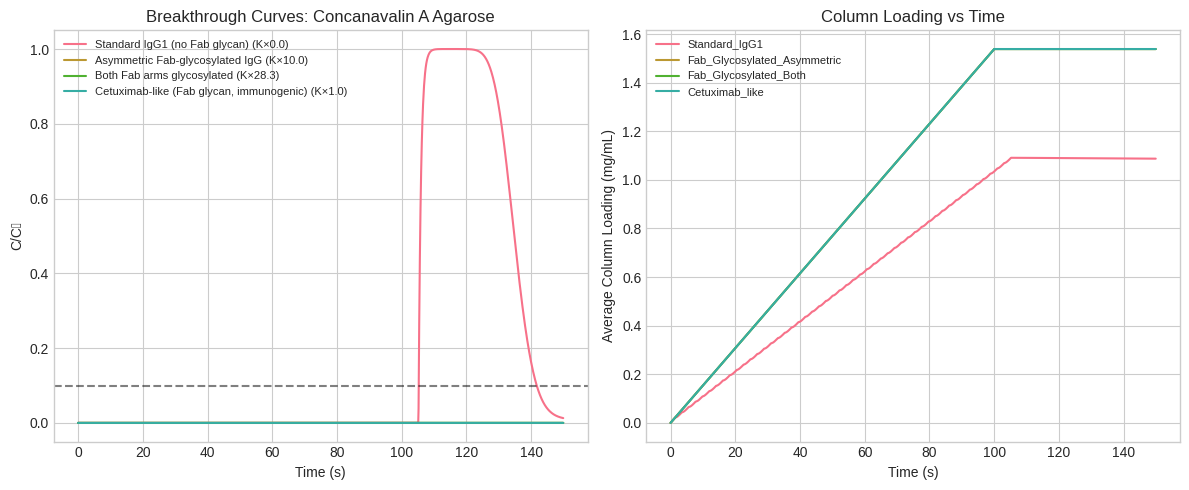

In [6]:
def simulate_glycoform_separation(resin_name: str,
                                  glycoforms: Dict[str, AntibodyGlycoform],
                                  C_feed: float = 1.0,
                                  t_load: float = 100.0):
    """
    Simulate separation of antibody glycoforms on specified resin.
    """
    # Get base resin parameters
    base_resin = RESIN_LIBRARY[resin_name]

    # Column parameters (standard analytical column)
    column = ColumnParameters(
        L=10.0,  # 10 cm
        D=0.77,  # 0.77 cm (standard prep column)
        u=0.1,   # cm/s
        DL=0.01  # cm^2/s
    )

    results = {}

    plt.figure(figsize=(12, 5))

    # Subplot 1: Breakthrough curves
    plt.subplot(1, 2, 1)

    for name, glycoform in glycoforms.items():
        # Modify resin parameters based on glycoform
        if 'ConA' in resin_name:
            affinity_mult = glycoform.get_cona_affinity_multiplier()
        elif 'Boronate' in resin_name:
            affinity_mult = glycoform.get_boronate_affinity_multiplier()
        else:
            affinity_mult = 1.0

        # Create modified resin
        modified_resin = ResinParameters(
            **{**vars(base_resin),
               'KA': base_resin.KA * affinity_mult,
               'qmax': base_resin.qmax * min(affinity_mult, 2.0)}  # Cap capacity increase
        )

        # Simulate
        model = SimplifiedColumnModel(column, modified_resin)
        t, C_out, q_avg = model.simulate_breakthrough(C_feed, t_load)

        results[name] = {
            't': t,
            'C_out': C_out,
            'q_avg': q_avg,
            'affinity_mult': affinity_mult
        }

        plt.plot(t, C_out / C_feed, label=f"{glycoform.name} (K×{affinity_mult:.1f})")

    plt.xlabel('Time (s)')
    plt.ylabel('C/C₀')
    plt.title(f'Breakthrough Curves: {base_resin.name}')
    plt.legend(fontsize=8)
    plt.axhline(y=0.1, color='k', linestyle='--', alpha=0.5, label='10% breakthrough')

    # Subplot 2: Column loading profiles
    plt.subplot(1, 2, 2)

    for name, res in results.items():
        plt.plot(res['t'], res['q_avg'], label=name)

    plt.xlabel('Time (s)')
    plt.ylabel('Average Column Loading (mg/mL)')
    plt.title('Column Loading vs Time')
    plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

    return results

# Run simulation
results = simulate_glycoform_separation('ConA_Agarose', EXAMPLE_GLYCOFORMS)

## 6. Hybrid Model: Gaussian Process for Parameter Estimation

Following the approach from Narayanan et al. (2021), we use Bayesian optimization with Gaussian Process surrogate models to:

1. Learn difficult-to-measure parameters from breakthrough data
2. Optimize separation conditions
3. Transfer knowledge between similar antibodies

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

class HybridChromModel:
    """
    Hybrid mechanistic + ML model for chromatography.

    Uses Gaussian Process to learn residuals between mechanistic
    model predictions and experimental data.
    """

    def __init__(self, column: ColumnParameters, resin: ResinParameters):
        self.mechanistic_model = SimplifiedColumnModel(column, resin)

        # GP for learning model residuals
        kernel = ConstantKernel(1.0) * Matern(nu=2.5) + WhiteKernel(noise_level=0.1)
        self.gp_residual = GaussianProcessRegressor(
            kernel=kernel,
            n_restarts_optimizer=5,
            normalize_y=True
        )

        self.is_trained = False
        self.training_data = None

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            conditions: Dict):
        """
        Fit hybrid model to experimental data.

        X_train: Operating conditions [pH, salt, flow_rate, ...]
        y_train: Experimental breakthrough curves or DBC values
        conditions: Dict with C_feed, t_load, etc.
        """
        # Get mechanistic predictions
        mech_predictions = []
        for x in X_train:
            # Update model parameters based on conditions
            pred = self._mechanistic_predict(x, conditions)
            mech_predictions.append(pred)

        mech_predictions = np.array(mech_predictions)

        # Calculate residuals
        residuals = y_train - mech_predictions

        # Train GP on residuals
        self.gp_residual.fit(X_train, residuals)

        self.is_trained = True
        self.training_data = (X_train, y_train, mech_predictions)

    def predict(self, X: np.ndarray, conditions: Dict,
                return_std: bool = False):
        """
        Predict using hybrid model.
        """
        # Mechanistic prediction
        mech_pred = np.array([self._mechanistic_predict(x, conditions) for x in X])

        if not self.is_trained:
            if return_std:
                return mech_pred, np.zeros_like(mech_pred)
            return mech_pred

        # GP residual correction
        if return_std:
            residual_pred, residual_std = self.gp_residual.predict(X, return_std=True)
            return mech_pred + residual_pred, residual_std
        else:
            residual_pred = self.gp_residual.predict(X)
            return mech_pred + residual_pred

    def _mechanistic_predict(self, x: np.ndarray, conditions: Dict) -> float:
        """
        Get mechanistic model prediction for given conditions.
        Override in subclasses for specific condition mappings.
        """
        # Simple DBC prediction
        C_feed = conditions.get('C_feed', 1.0)
        return self.mechanistic_model.calculate_dbc(C_feed)


# Demonstration with synthetic data
print("Hybrid Model Framework Initialized")
print("Ready for experimental data integration")

Hybrid Model Framework Initialized
Ready for experimental data integration


## 7. Bayesian Optimization for Formulation/Process Design

Implementing the approach from the paper to optimize:
- pH and buffer composition
- Salt concentration
- Flow rate
- Loading concentration

In [8]:
from scipy.stats import norm

class BayesianOptimizer:
    """
    Bayesian Optimization for chromatography process optimization.
    Uses Expected Improvement acquisition function.
    """

    def __init__(self, bounds: Dict[str, Tuple[float, float]]):
        """
        bounds: Dict mapping parameter names to (min, max) tuples
        """
        self.bounds = bounds
        self.param_names = list(bounds.keys())
        self.n_params = len(bounds)

        # Initialize GP surrogate
        kernel = ConstantKernel(1.0) * Matern(nu=2.5) + WhiteKernel()
        self.gp = GaussianProcessRegressor(
            kernel=kernel,
            n_restarts_optimizer=10,
            normalize_y=True
        )

        self.X_observed = []
        self.y_observed = []

    def _to_array(self, params: Dict) -> np.ndarray:
        return np.array([params[name] for name in self.param_names])

    def _to_dict(self, x: np.ndarray) -> Dict:
        return {name: val for name, val in zip(self.param_names, x)}

    def expected_improvement(self, X: np.ndarray, xi: float = 0.01) -> np.ndarray:
        """
        Calculate Expected Improvement acquisition function.
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])

        mu, sigma = self.gp.predict(X, return_std=True)

        mu_best = np.max(self.y_observed)

        with np.errstate(divide='warn'):
            imp = mu - mu_best - xi
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0

        return ei

    def suggest_next(self, n_candidates: int = 1000) -> Dict:
        """
        Suggest next experiment using acquisition function optimization.
        """
        # Generate candidate points
        candidates = np.random.uniform(
            low=[b[0] for b in self.bounds.values()],
            high=[b[1] for b in self.bounds.values()],
            size=(n_candidates, self.n_params)
        )

        # Evaluate acquisition function
        ei = self.expected_improvement(candidates)

        # Return best candidate
        best_idx = np.argmax(ei)
        return self._to_dict(candidates[best_idx])

    def update(self, params: Dict, value: float):
        """
        Update model with new observation.
        """
        x = self._to_array(params)
        self.X_observed.append(x)
        self.y_observed.append(value)

        # Refit GP
        X = np.array(self.X_observed)
        y = np.array(self.y_observed)
        self.gp.fit(X, y)

    def get_best(self) -> Tuple[Dict, float]:
        """Return best observed parameters and value."""
        if len(self.y_observed) == 0:
            return None, None

        best_idx = np.argmax(self.y_observed)
        return self._to_dict(self.X_observed[best_idx]), self.y_observed[best_idx]


# Example: Optimize ConA elution conditions
optimizer = BayesianOptimizer({
    'pH': (3.0, 7.0),
    'mannose_conc': (0.0, 0.5),  # M
    'flow_rate': (0.5, 3.0)  # mL/min
})

print("Bayesian Optimizer initialized for ConA elution optimization")
print(f"Parameters: {optimizer.param_names}")
print(f"Bounds: {optimizer.bounds}")

Bayesian Optimizer initialized for ConA elution optimization
Parameters: ['pH', 'mannose_conc', 'flow_rate']
Bounds: {'pH': (3.0, 7.0), 'mannose_conc': (0.0, 0.5), 'flow_rate': (0.5, 3.0)}


## 8. Integration with Glycosylation Scanner

This section connects the chromatography model to your Enhanced Progenitor Glycosylation Scanner outputs.

In [9]:
def predict_glycoform_separation_from_scanner(
    scanner_output: Dict,
    resin_type: str = 'ConA_Agarose'
) -> Dict:
    """
    Predict chromatographic behavior from glycosylation scanner output.

    scanner_output should contain:
    - sequence: amino acid sequence
    - predicted_glycan_sites: list of (position, probability, glycan_type)
    - fab_region: (start, end) positions
    - fc_region: (start, end) positions
    """
    # Parse scanner output
    fab_sites = [s for s in scanner_output.get('predicted_glycan_sites', [])
                 if scanner_output['fab_region'][0] <= s[0] <= scanner_output['fab_region'][1]]

    # Create glycoform object
    n_fab_sites = len([s for s in fab_sites if s[1] > 0.5])  # High confidence

    # Determine most likely glycan type
    glycan_types = [s[2] for s in fab_sites if s[1] > 0.5]
    primary_type = max(set(glycan_types), key=glycan_types.count) if glycan_types else 'none'

    glycoform = AntibodyGlycoform(
        name=f"Scanner_Predicted (n={n_fab_sites})",
        fab_glycan_sites=n_fab_sites,
        fab_glycan_type=primary_type,
        fc_glycan_type='G0F',  # Default
        fc_sialylation=0.1,
        mw=150.0 + 2.0 * n_fab_sites,
        pI=8.5 - 0.2 * n_fab_sites
    )

    # Predict chromatographic behavior
    resin = RESIN_LIBRARY[resin_type]

    predictions = {
        'glycoform': glycoform,
        'cona_affinity_multiplier': glycoform.get_cona_affinity_multiplier(),
        'boronate_affinity_multiplier': glycoform.get_boronate_affinity_multiplier(),
        'predicted_retention': 'Strong' if glycoform.get_cona_affinity_multiplier() > 5 else
                              'Moderate' if glycoform.get_cona_affinity_multiplier() > 1 else 'Weak',
        'manufacturing_risk': 'HIGH' if n_fab_sites > 0 else 'LOW',
        'recommended_screening': ['ConA affinity', 'Size exclusion'] if n_fab_sites > 0 else ['Standard QC']
    }

    return predictions


# Example: Simulate scanner output for a problematic antibody
example_scanner_output = {
    'sequence': 'EXAMPLE_VH_SEQUENCE...',
    'predicted_glycan_sites': [
        (52, 0.85, 'high-mannose'),  # High confidence Fab site
        (297, 0.99, 'complex'),       # Standard Fc site
    ],
    'fab_region': (1, 220),
    'fc_region': (221, 450)
}

predictions = predict_glycoform_separation_from_scanner(example_scanner_output)
print("\nGlycosylation Scanner → Chromatography Predictions:")
print("=" * 50)
for key, value in predictions.items():
    if key != 'glycoform':
        print(f"{key}: {value}")


Glycosylation Scanner → Chromatography Predictions:
cona_affinity_multiplier: 10.0
boronate_affinity_multiplier: 3.1500000000000004
predicted_retention: Strong
manufacturing_risk: HIGH
recommended_screening: ['ConA affinity', 'Size exclusion']


## 9. Summary and Next Steps

### What This Framework Provides:

1. **Mechanistic column model** with Langmuir kinetics
2. **Glycoform-specific binding** predictions for ConA and boronate resins
3. **Hybrid ML/mechanistic** approach using Gaussian Processes
4. **Bayesian optimization** for process development
5. **Integration pathway** with glycosylation scanner

### Data Needed for Validation:

| Data Type | Source | Priority |
|-----------|--------|----------|
| ConA breakthrough curves | Literature/Experiments | High |
| IgG binding isotherms | Vendor data sheets | High |
| Glycoform separation data | Published separations | Medium |
| Boronate binding kinetics | Literature | Medium |
| Protein A comparison data | Internal/Published | Low |

### Key Publications to Mine:

1. Narayanan et al. (2021) - Hybrid models for chromatography
2. Fractionation of Fab glycosylated IgG with ConA (Oncotarget 2016)
3. Boronate affinity chromatography reviews
4. SMA isotherm parameters for mAbs on various resins

In [10]:
# Save notebook state for later use
print("\n" + "="*60)
print("HYBRID CHROMATOGRAPHY MODEL FRAMEWORK")
print("AntibodyML Consulting LLC")
print("="*60)
print(f"\nResins modeled: {list(RESIN_LIBRARY.keys())}")
print(f"Glycoforms defined: {list(EXAMPLE_GLYCOFORMS.keys())}")
print("\nReady for experimental data integration!")


HYBRID CHROMATOGRAPHY MODEL FRAMEWORK
AntibodyML Consulting LLC

Resins modeled: ['ConA_Agarose', 'Boronate_PBA', 'MabSelect_SuRe', 'Capto_S_ImpRes']
Glycoforms defined: ['Standard_IgG1', 'Fab_Glycosylated_Asymmetric', 'Fab_Glycosylated_Both', 'Cetuximab_like']

Ready for experimental data integration!
